In [324]:
# All imports (TODO: Add appropriate packages if necessary)
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from utils import *

%reload_ext autoreload
%autoreload 2

# Load data
x0 = np.loadtxt('../../data/nonlinear_vectorfield_data_x0.txt')
x1 = np.loadtxt('../../data/nonlinear_vectorfield_data_x1.txt')

### TODO: Part 1 - Estimate the vector field with a linear operator and compute mean squared error to the solution after $\Delta t$

In [325]:
# choose small delta_T and compute initial vector field v accordingly
delta_T = 0.01
v = (x1-x0)/delta_T

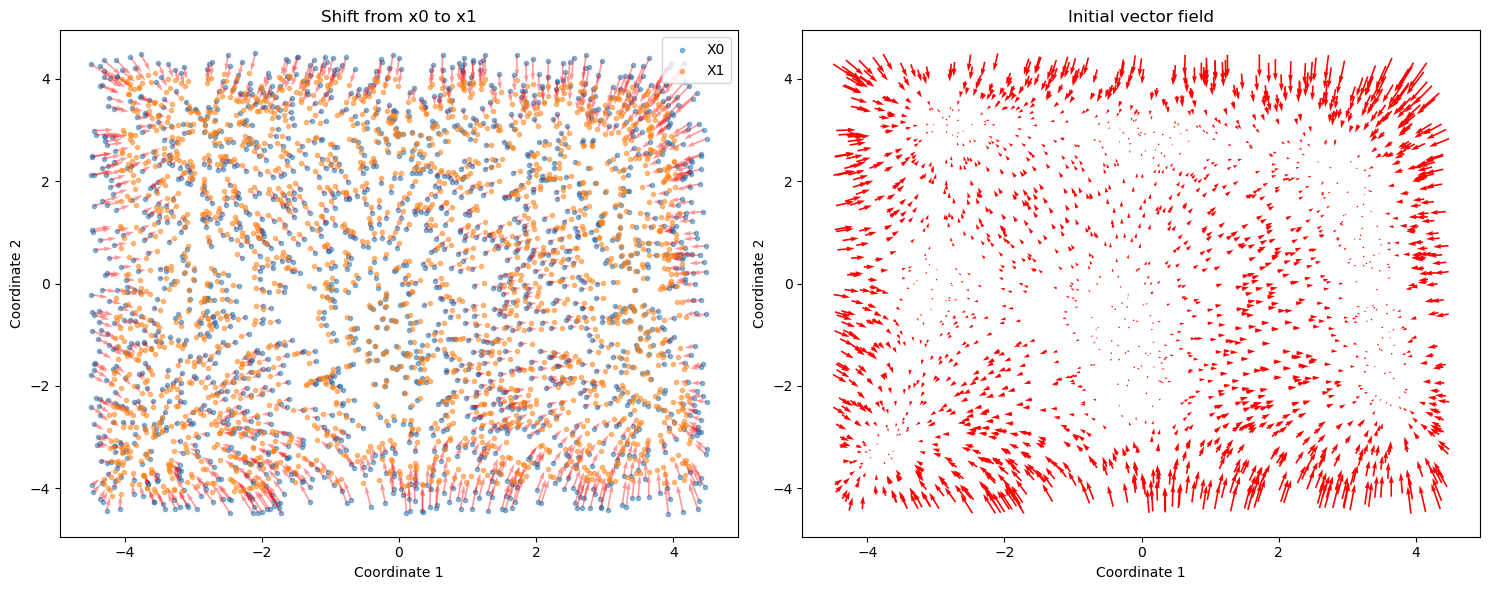

In [428]:
fig, ax = plt.subplots(1,2, figsize =(15,6))

ax[0].scatter(*x0.T, label = 'X0', alpha= 0.5, marker= '.')
ax[0].quiver(*x0.T, *v.T, color= 'r', alpha = 0.4)
ax[0].scatter(*x1.T, label = 'X1', alpha=0.5, marker= '.')
ax[0].legend()
ax[0].set_xlabel("Coordinate 1")
ax[0].set_ylabel("Coordinate 2")
ax[0].set_title("Shift from x0 to x1")
ax[1].quiver(x0[:,0], x0[:,1], v[:,0], v[:,1], color= 'r')
ax[1].set_xlabel("Coordinate 1")
ax[1].set_ylabel("Coordinate 2")
ax[1].set_title("Initial vector field")
plt.tight_layout()
plt.savefig('../../plot/visualization_nonlinear_x0_x1.png')
plt.show()

Vector field is way more complex than in task 2, looks non linear.

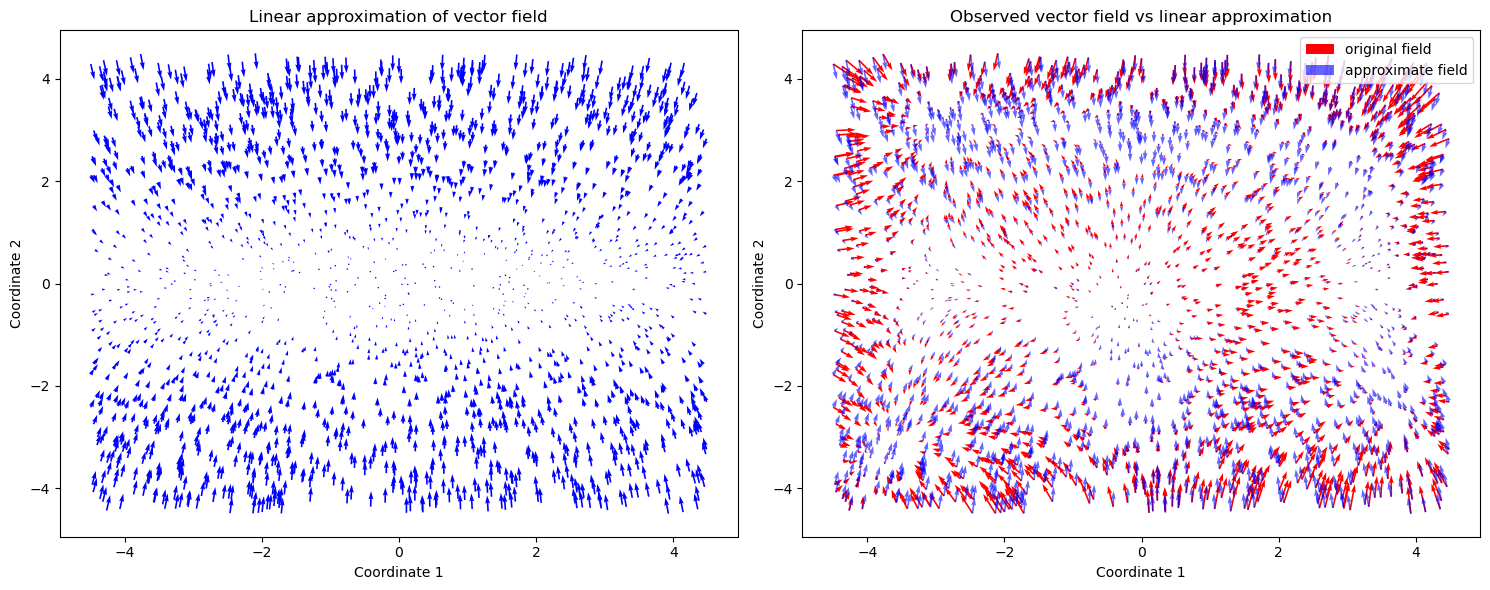

In [429]:
#A_estim = least_squares(x0,v)[0:2,0:2]
#approx = x0@A_estim
linear_approx_field = linear_fit_transform(x0,v)[0]

fig, ax = plt.subplots(1,2, figsize =(15,6))
ax[0].quiver(*x0.T, *linear_approx_field.T, color= 'b')
ax[0].set_xlabel("Coordinate 1")
ax[0].set_ylabel("Coordinate 2")
ax[0].set_title("Linear approximation of vector field")
ax[1].quiver(*x0.T, *v.T, color= 'r', label= 'original field')
ax[1].quiver(*x0.T, *linear_approx_field.T, color= 'b', alpha= 0.6, label ='approximate field')
ax[1].set_xlabel("Coordinate 1")
ax[1].set_ylabel("Coordinate 2")
ax[1].set_title("Observed vector field vs linear approximation")
ax[1].legend()
plt.tight_layout()
plt.savefig('../../plot/linear_field_comparison_2.png')
plt.show()

As seen from the second graph, the linear approximation of the vector field doesnt really match the observation. Indeed, linear approximation converges toward origin, whereas the data shows more complex behavior and a potential existence of steady states on the edges and corner of the state space, confirming intuition of non linear vector field.

In [430]:
# same procedure as task 2, f is the time derivative of flow operator and will be integrated to compute approximation of x1
A_estim = least_squares(x0,v)[0]
def f(t, y):
    y = y.reshape(2000,2)
    return np.dot(y, A_estim).flatten()

In [431]:
# Reuse of our x1_estim function built for task 2, integration over delta_T to compute x1 approximate
#linear_approx_x1 = x1_estim(f,x0, delta_T)
test = solve_ivp(f, [0,delta_T],x0.flatten(), t_eval=[delta_T])
linear_approx_x1 = test.y.reshape(2000,2)
mean_squared_error(x1,linear_approx_x1)

0.03727581844374586

The MSE between all the approximated and known end points for Delta_T = 0.01 is 0.037, which is quite high when compared to MSEs encountered in the previous tasks. What will truly be determinant though, will be the comparison between this MSE (linear model approximation) and the MSE of non linear model approximation; even though we might already consider the vector field highly likely to be non linear.

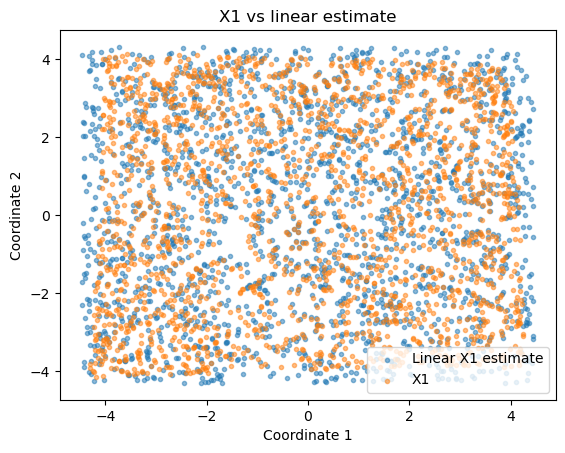

In [432]:
plt.scatter(linear_approx_x1[:,0],linear_approx_x1[:,1], label = 'Linear X1 estimate', alpha= 0.5, marker='.')
plt.scatter(x1[:,0], x1[:,1], label = 'X1', alpha=0.5, marker= '.')
plt.xlabel("Coordinate 1")
plt.ylabel("Coordinate 2")
plt.title("X1 vs linear estimate")
plt.savefig("../../plot/linear_estimate_x1_2.png")
plt.legend()

### TODO: Part 2 - Approximate the vector field with RBF and compute mean squared error to the solution after $\Delta t$

In [486]:
L = 100
epsilon = 0.05
#x = np.linspace(-4.5, 4.5, L)
#centers = 9*np.random.random_sample((L,2)) -4.5
# Generate points using meshgrid
x, y = np.meshgrid(np.linspace(-4.5, 4.5, int(np.sqrt(L))), np.linspace(-4.5, 4.5, int(np.sqrt(L))))

# Combine points to get centers on 2D domain
centers = np.vstack([x.ravel(), y.ravel()]).T

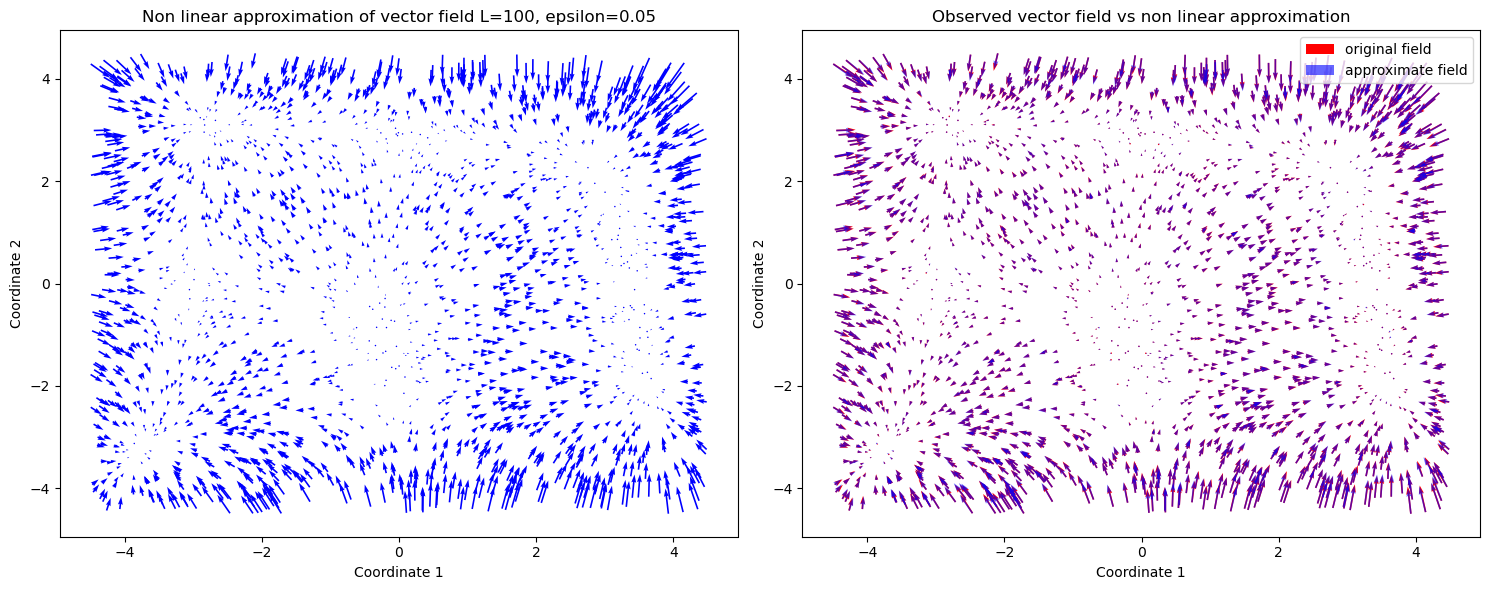

In [487]:
#phi = approx_non_linear_field(x0,centers, 0.08)
#C =  least_squares(phi.T, v)
#approx_field = np.dot(phi.T, C)
non_linear_approx_field = non_linear_fit_transform(x0,v, centers, epsilon)[0]

fig, ax = plt.subplots(1,2, figsize =(15,6))
ax[0].quiver(x0[:,0], x0[:,1], non_linear_approx_field[:,0], non_linear_approx_field[:,1], color= 'b')
ax[0].set_xlabel("Coordinate 1")
ax[0].set_ylabel("Coordinate 2")
ax[0].set_title(f"Non linear approximation of vector field L={L}, epsilon={epsilon}")
ax[1].quiver(x0[:,0], x0[:,1], v[:,0], v[:,1], color= 'r', label= 'original field')
ax[1].quiver(x0[:,0], x0[:,1], non_linear_approx_field[:,0], non_linear_approx_field[:,1], color= 'b', alpha= 0.6, label ='approximate field')
ax[1].set_xlabel("Coordinate 1")
ax[1].set_ylabel("Coordinate 2")
ax[1].set_title("Observed vector field vs non linear approximation")
plt.tight_layout()
plt.legend()
plt.savefig('../../plot/nonlinear_field_estimate.png')
plt.show()

In [488]:
C = non_linear_fit_transform(x0,v, centers, epsilon)[1]

In [489]:
def g(t, y):
    y = y.reshape(-1,2)
    phi = approx_non_linear_field(y,centers, epsilon)
    #C =  least_squares(phi_.T, v)
    #return np.dot(phi_.T,C).flatten()
    return transform(phi,C).flatten()

SOL = solve_ivp(g, [0,delta_T], x0.flatten(), t_eval= [delta_T])
x1_estim_non_linear = SOL.y.reshape(2000,2)
mean_squared_error(x1_estim_non_linear, x1)

0.0018704763253842823

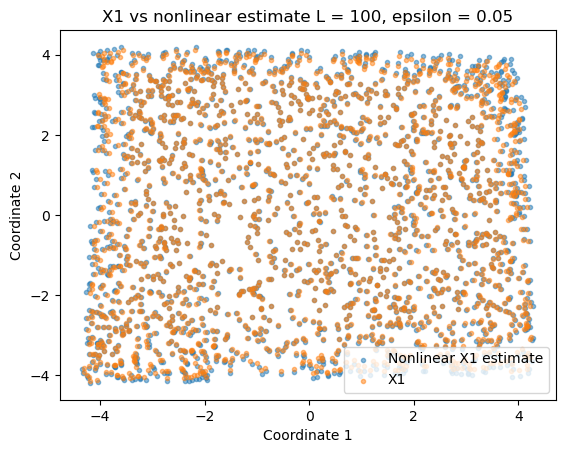

In [500]:
plt.scatter(*x1_estim_non_linear.T, label = 'Nonlinear X1 estimate', alpha= 0.5, marker='.')
plt.scatter(*x1.T, label = 'X1', alpha=0.5, marker= '.')
plt.xlabel("Coordinate 1")
plt.ylabel("Coordinate 2")
plt.title(f"X1 vs nonlinear estimate L = {L}, epsilon = {epsilon}")
plt.savefig("../../plot/nonlinear_estimate_x1.png")
plt.legend()

MSE of roughly 10-03 (L=100, eps=0.1) for non linear model VS MSE of 3e-02 for Linear model. Vector field is most likely non linear! Error is indeed 100 times smaller for non linear model, it is a better representation of reality than linear model.

#### Comparing with SciPy built-in RBF interpolator

In [491]:
rbf = built_int_interpolator(x0,v,0.9)

def g_cheat(t, y):
    y = y.reshape(2000,2)
    return  rbf(y).flatten()
SOL_cheat = solve_ivp(g_cheat, [0,delta_T], x0.flatten(), t_eval= [delta_T])
x1_approx_cheat = SOL_cheat.y.reshape(2000,2)
mean_squared_error(x1, x1_approx_cheat)

0.0008437067847868198

MSE of roughly 10e-03 confirming non linear model as better than linear model. Smaller error than our RBF can be explained by the regularization used in our implementation.

### TODO: Part 3 - Analysis of the system

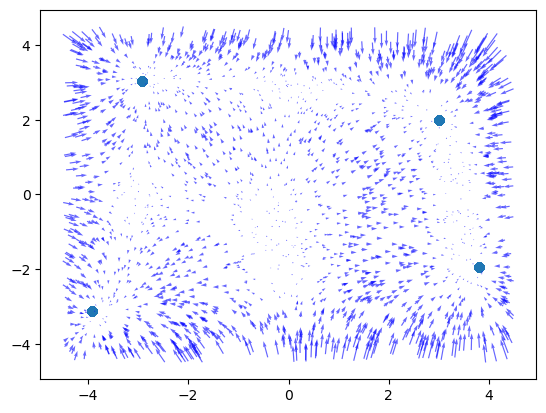

In [492]:
T_end = 10
#t_evals_2 = np.linspace(0,15,10)
solve_2 = solve_ivp(g, [0,T_end], x0.flatten(), t_eval= [T_end])
end_points = solve_2.y.reshape(2000,2)
plt.scatter(*end_points.T)
plt.quiver(*x0.T, *non_linear_approx_field.T, color= 'b', alpha= 0.6, label ='approximate field')

After a large amount of time (1000 timsteps) points end up in 8 locations, ie this dynamical system has 8 steady states.

In [495]:
#plt.scatter(*np.unique(end_points, axis=0)[1:3].T)

#### Phase portrait

In [496]:
# Create a grid of points over the domain
x = np.linspace(-5, 5, 100)
y = np.linspace(-5, 5, 100)
X, Y = np.meshgrid(x, y)
positions = np.vstack([X.ravel(), Y.ravel()]).T

vector_stream = g(0,positions).reshape(len(x)**2,2)
U = vector_stream[:,0].reshape(X.shape)
V = vector_stream[:,1].reshape(Y.shape)

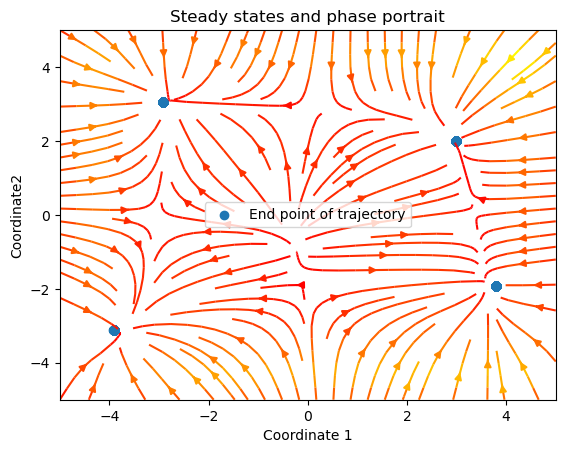

In [498]:
plt.streamplot(X, Y, U, V, color =np. sqrt (U ** 2 + V ** 2), cmap = 'autumn')
plt.scatter(*end_points.T, label= 'End point of trajectory')
plt.xlabel("Coordinate 1")
plt.ylabel('Coordinate2')
plt.title("Steady states and phase portrait")
plt.legend()
plt.savefig("../../plot/nonlinear_analysis.png")
plt.show()

#### Trajectories

In [501]:
T_end = 10
t_evals_2 = np.linspace(0,T_end, 30)
solve_traj = solve_ivp(g, [0,T_end], x0.flatten(), t_eval= t_evals_2)

Text(0.5, 1.0, 'Predicted end of trajectory')

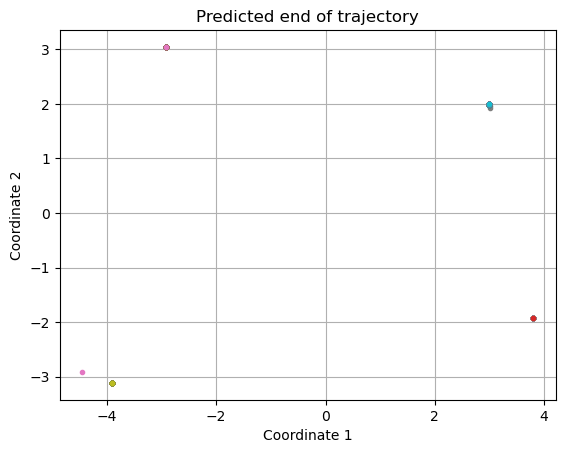

In [502]:
list_sol = []
for i in range(len(t_evals_2)):
 list_sol.append(solve_traj.y[:,i].reshape(2000,2))
trajectories = []
for j in range(len(x0)):
    trajectory = []
    for i in range(len(t_evals_2)):
        trajectory.append(list_sol[i][j])
    trajectories.append(trajectory)
for k in range(len(trajectories)) :
    trajectory_k = np.array(trajectories[k])
    plt.plot(trajectory_k[T_end,0],trajectory_k[T_end,1], '.')
    #print(trajectory_k[99,0])
    #print(trajectory_k[99,1])
    #plt.plot(-0.74680196,  1.98292044, 'o', color = 'r')
    plt.xlabel("Coordinate 1")
    plt.ylabel("Coordinate 2")
#plt.quiver(x0[:,0], x0[:,1], approx_field[:,0], approx_field[:,1], color= 'r')
#plt.scatter(x0[:,0],x0[:,1], label = 'X0', alpha= 0.5, marker= '.')
plt.grid()
plt.title("Predicted end of trajectory")

Text(0.5, 1.0, 'Trajectories')

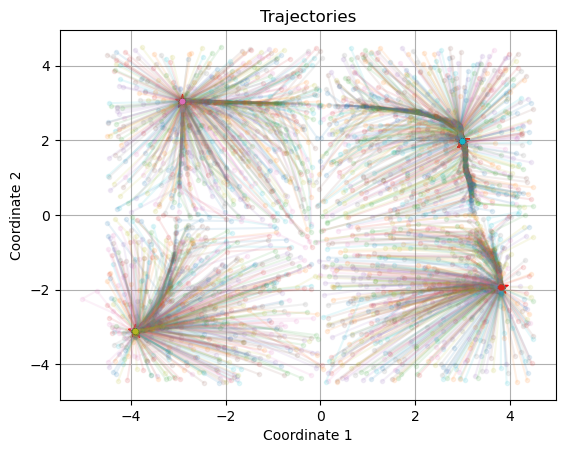

In [503]:
list_sol_2 = []
for i in range(len(t_evals_2)):
 list_sol_2.append(solve_traj.y[:,i].reshape(2000,2))

trajectories_2 = []
for j in range(len(x0)):
    trajectory = []
    for i in range(len(t_evals_2)):
        trajectory.append(list_sol_2[i][j])
    trajectories_2.append(trajectory)

for k in range(len(trajectories_2)) :
    trajectory_k = np.array(trajectories_2[k])
    #for i in range(0,len(t_evals_2)):
        #print(i)
    #plt.plot(trajectory_k[:,0],trajectory_k[:,1], marker='.', alpha = 0.1)
    plt.plot(*trajectory_k.T, marker='.', alpha = 0.1)
        #print(trajectory_k[99,0])
        #print(trajectory_k[99,1])
        #plt.plot(-0.74680196,  1.98292044, 'o', color = 'r')
#plt.scatter(*unique_endpoints.T, color = 'r', s= 100)
plt.scatter(*end_points.T, color = 'r', s= 100, marker = '*')
#plt.streamplot(X, Y, U, V, color =np. sqrt (U ** 2 + V ** 2), cmap = 'autumn')
plt.xlabel("Coordinate 1")
plt.ylabel("Coordinate 2")
#plt.quiver(x0[:,0], x0[:,1], approx_field[:,0], approx_field[:,1], color= 'r')
#plt.scatter(x0[:,0],x0[:,1], label = 'X0', alpha= 0.5, marker= '.')
plt.grid()
plt.title("Trajectories")

Text(0.5, 1.0, 'Trajectories')

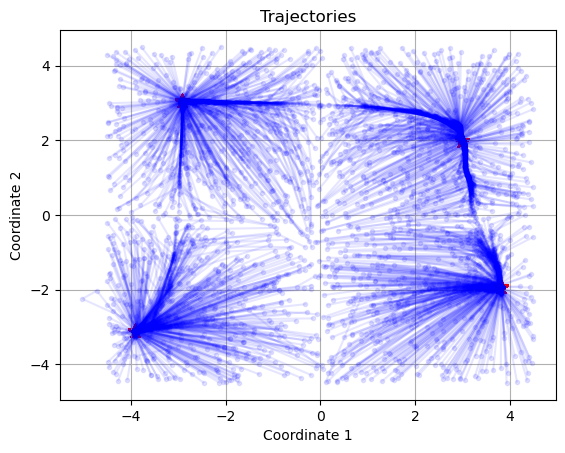

In [505]:
plt.plot(*solve_traj.y, marker= '.', alpha = .1, color= 'b')
plt.scatter(*end_points.T, color = 'r', s= 100, marker = '*')
plt.xlabel("Coordinate 1")
plt.ylabel("Coordinate 2")
plt.grid()
plt.title("Trajectories")